# Typology for doubles

1. Identify 2-artifact clusters (pairs of contiguous artifacts); make sure that the union has no interior
2. For each cluster, classify the inside edge as C or nonC (`drop_interline`: bool)
3. Visualize and test if it works

- number of nodes
- number of continuity groups
- filter non-planarity artifacts
- CES counts
- prime detection
- crosses detection
- touches detecion

In [1]:
import logging

import geopandas as gpd
import matplotlib.pyplot as plt
import momepy
import numpy as np
import pandas as pd
import shapely
from libpysal import graph
from scipy import sparse
import folium
import folium.plugins as plugins
import shapely

from core import algorithms, utils
from core.geometry import voronoi_skeleton, remove_false_nodes

In [2]:
logging.basicConfig(level=logging.DEBUG)

Specify case metadata

In [3]:
case = "Liège"

Read road data

In [4]:
roads = utils.read_original(case)

Remove duplicated roads

In [5]:
roads = momepy.remove_false_nodes(roads)
roads = roads[~roads.geometry.duplicated()].reset_index()
roads = momepy.remove_false_nodes(roads)

Identify artifacts

In [6]:
artifacts = momepy.FaceArtifacts(roads).face_artifacts.set_crs(roads.crs)
artifacts["id"] = artifacts.index

Remove edges fully within the artifact (dangles).

In [7]:
a_idx, _ = roads.sindex.query(artifacts.geometry, predicate="contains")
artifacts = artifacts.drop(artifacts.index[a_idx])

Filter doubles

In [8]:
rook = graph.Graph.build_contiguity(artifacts, rook=True)
artifacts["comp"] = rook.component_labels
counts = artifacts["comp"].value_counts()
artifacts = artifacts.loc[artifacts["comp"].isin(counts[counts == 2].index)]

Optionally define a subset of data.

In [15]:
data_sample = artifacts.sort_values("comp").iloc[:20].copy()

In [10]:
def _classify_interline(mycluster, artifacts, roads):
    # get the cluster geometry
    cluster_geom = artifacts[artifacts.comp == mycluster].union_all()

    # find the road segment that is contained within the cluster geometry
    road_contained = roads.sindex.query(cluster_geom, predicate="contains")

    # make sure we have uniquely identified the road segment
    if len(road_contained) == 1:

        # return the ID of the road segment (to potentially drop later)
        # and coins_end True/False
        return pd.Series([road_contained[0], roads.loc[road_contained]["coins_end"].values[0]])
    else:
        return pd.Series([None, None])

In [14]:
def simplify_pairs(artifacts, roads, distance=2):
    # Get nodes from the network.
    nodes = momepy.nx_to_gdf(momepy.node_degree(momepy.gdf_to_nx(roads)), lines=False)

    # Link nodes to artifacts
    node_idx, artifact_idx = artifacts.sindex.query(
        nodes.buffer(0.1), predicate="intersects"
    )
    intersects = sparse.coo_array(
        ([True] * len(node_idx), (node_idx, artifact_idx)),
        shape=(len(nodes), len(artifacts)),
        dtype=np.bool_,
    )

    # Compute number of nodes per artifact
    artifacts["node_count"] = intersects.sum(axis=0)

    # Compute number of stroke groups per artifact
    roads, _ = algorithms.common.continuity(roads)
    strokes, c_, e_, s_ = algorithms.common.get_stroke_info(artifacts, roads)

    artifacts["stroke_count"] = strokes
    artifacts["C"] = c_
    artifacts["E"] = e_
    artifacts["S"] = s_

    # LOOP 0 - drop and treat as a whole
    # TODO: include half on non-dropping

    # Filer artifacts caused by non-planar intersections.
    artifacts["non_planar"] = artifacts["stroke_count"] > artifacts["node_count"]
    a_idx, _ = roads.sindex.query(artifacts.geometry.boundary, predicate="overlaps")
    artifacts.iloc[np.unique(a_idx), -1] = True

    # Remove (for now) the clusters that contain at least one non-planar component
    # (TODO: we will deal with them later, ...?)
    # non_planar_cluster: number of non-planar artifacts per cluster
    artifacts["non_planar_cluster"] = artifacts.apply(
        lambda x: sum(artifacts.loc[artifacts["comp"] == x.comp]["non_planar"]), axis=1
    )
    # dealing with the non-planar later!
    artifacts = artifacts[artifacts.non_planar_cluster == 0]

    apply_r = artifacts.comp.apply(
        lambda x: _classify_interline(x, artifacts, roads)
    )

    # TODO: change the detection drop_interline. Check if the two parts agree on the
    # classification of the interline. If they do agree and it is E or S, drop and pass
    # through singleton solution. If they argree and it is C, deal iteratively one by
    # one. If they disagree, use nx_gx_cluster.

    artifacts["inter_road"] = apply_r[0]
    artifacts["inter_coins_end"] = apply_r[1]
    artifacts["drop_interline"] = artifacts["inter_coins_end"]

    # if one of the 2 artifacts is of type 0C0EnS, then no matter whether
    # inter_coins_end is True or False! it will always be S
    comps_with_s = list(artifacts[(artifacts.C == 0) & (artifacts.E == 0)].comp)
    artifacts.loc[artifacts["comp"].isin(comps_with_s), "drop_interline"] = True

    to_drop = (
        artifacts.drop_duplicates("comp").query("drop_interline == True").inter_road
    )
    merged_pairs = artifacts.query("drop_interline == True").dissolve("comp")

    roads_cleaned = remove_false_nodes(roads.drop(to_drop.dropna().values))

    loop_1 = algorithms.simplify.simplify_singletons(
        merged_pairs, roads_cleaned, distance=distance, compute_coins=False
    )

    # LOOP_2
    # TODO: second half
    return loop_1, roads_cleaned, merged_pairs

In [16]:
new_roads, roads_cleaned, merged_pairs = simplify_pairs(data_sample, roads)

/Users/martin/miniforge3/envs/simplification/lib/python3.11/site-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/Users/martin/miniforge3/envs/simplification/lib/python3.11/site-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/Users/martin/miniforge3/envs/simplification/lib/python3.11/site-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is tr

3


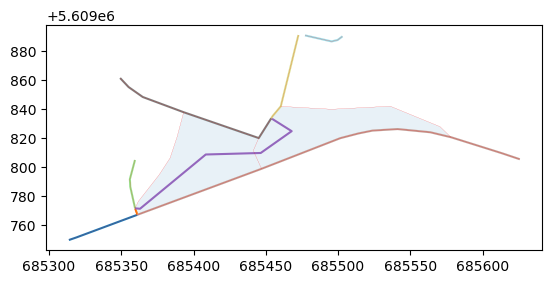

6


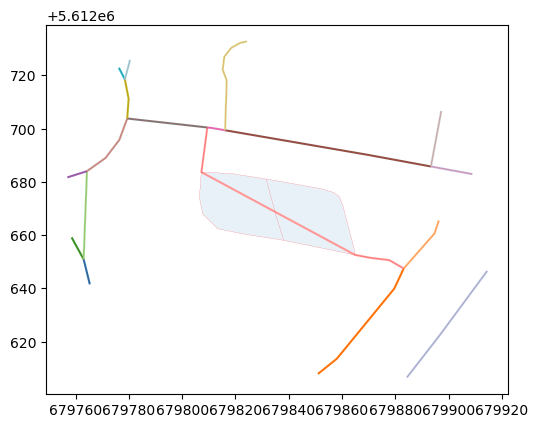

22


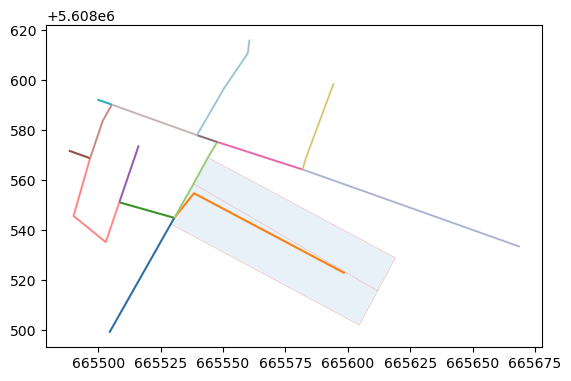

37


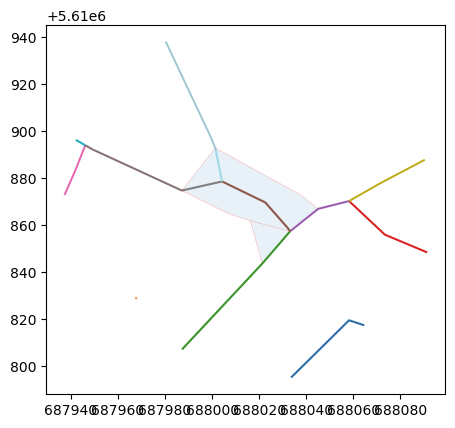

38


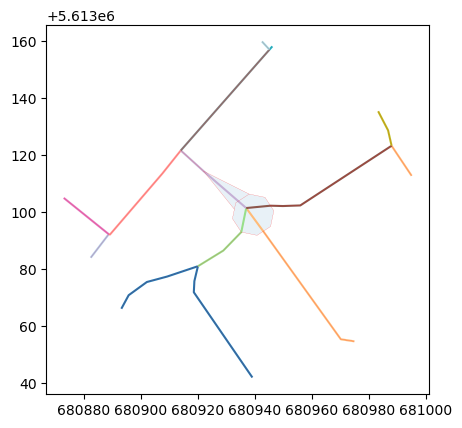

45


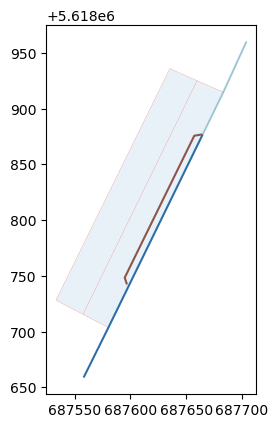

46


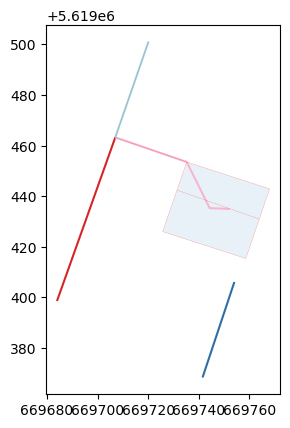

48


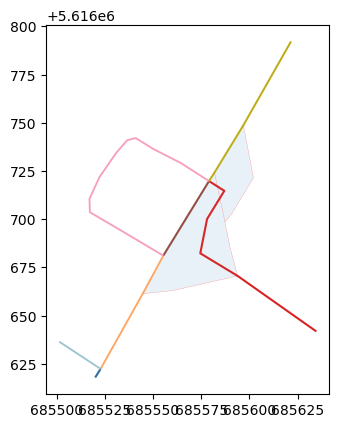

50


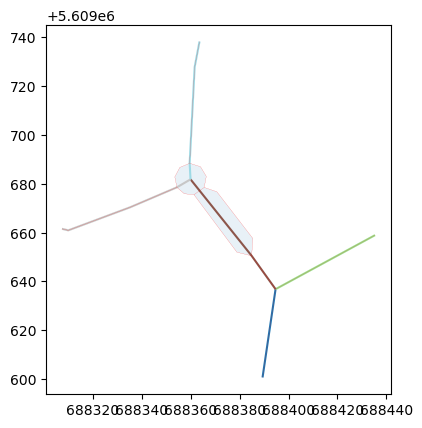

56


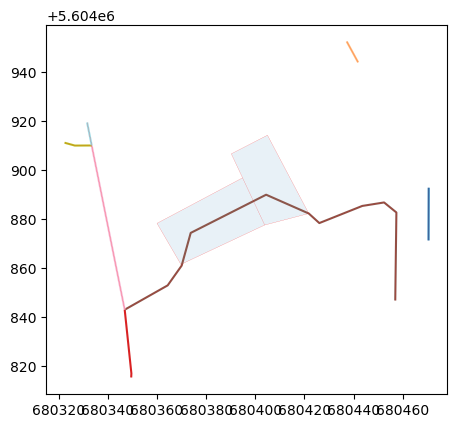

61


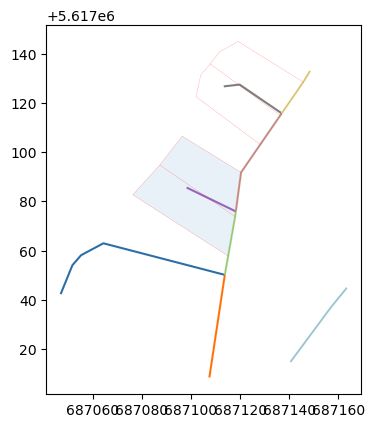

72


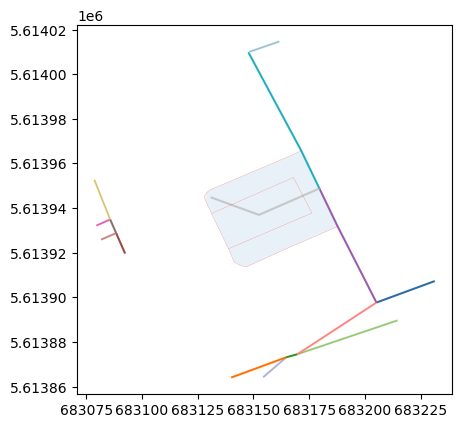

74


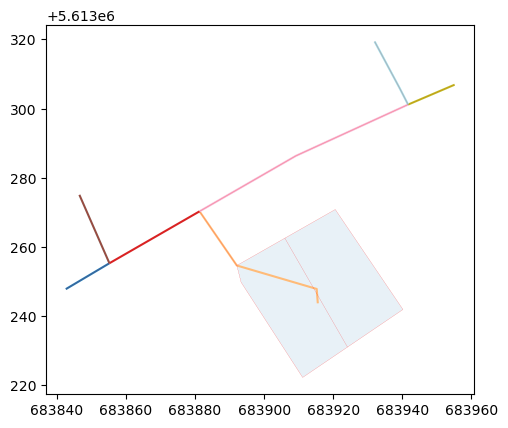

88


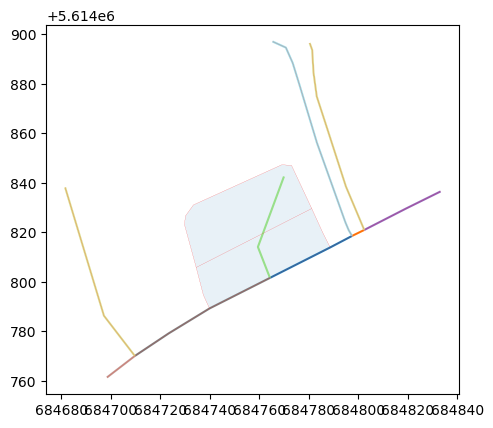

93


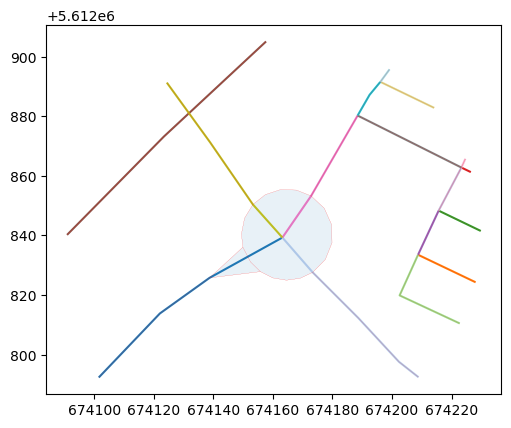

95


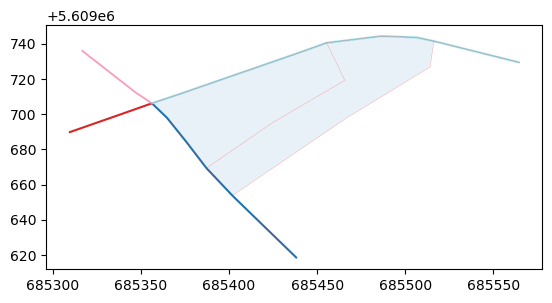

96


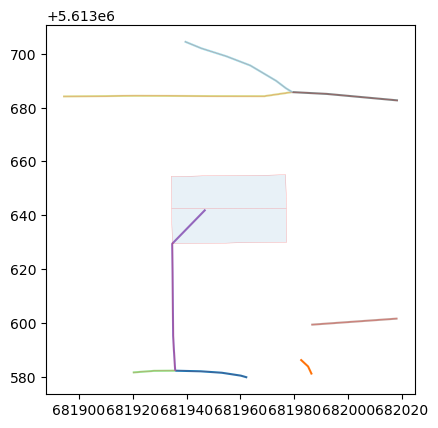

98


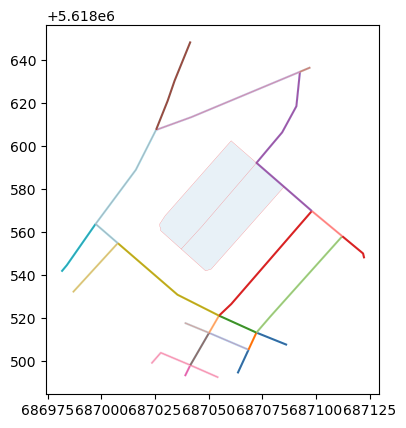

128


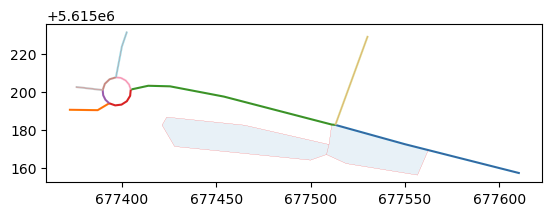

137


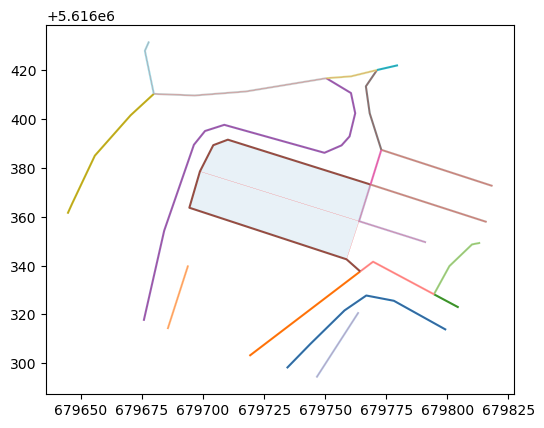

147


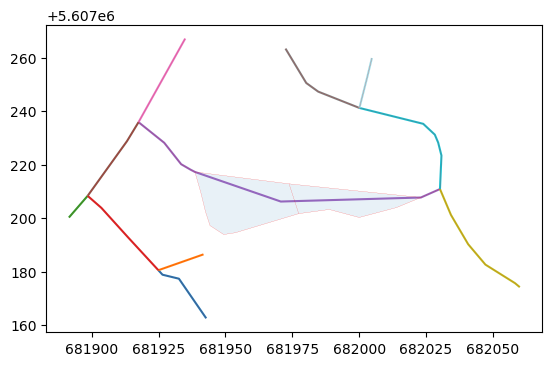

149


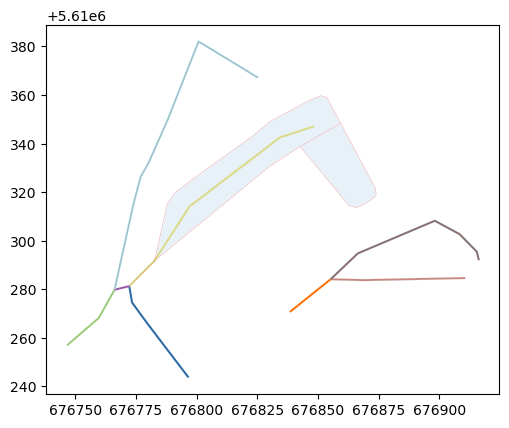

161


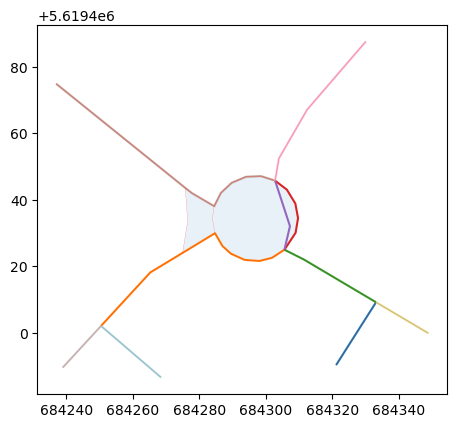

173


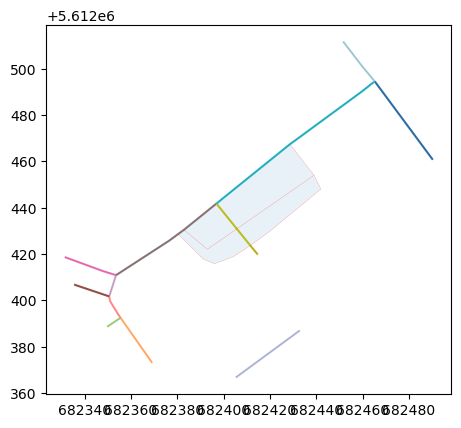

189


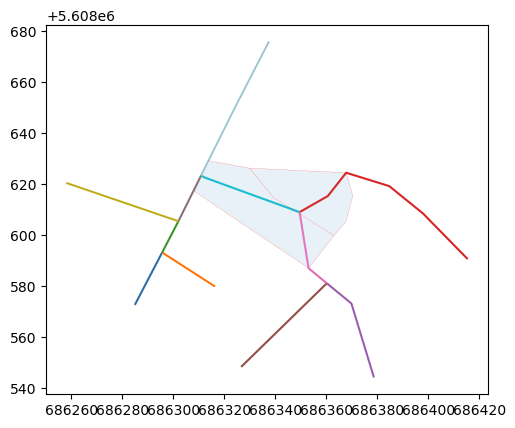

197


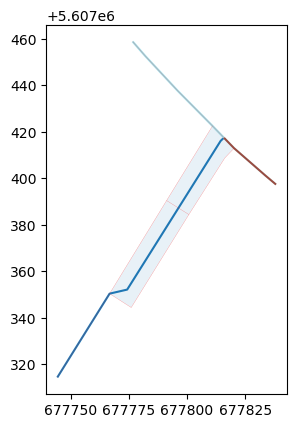

231


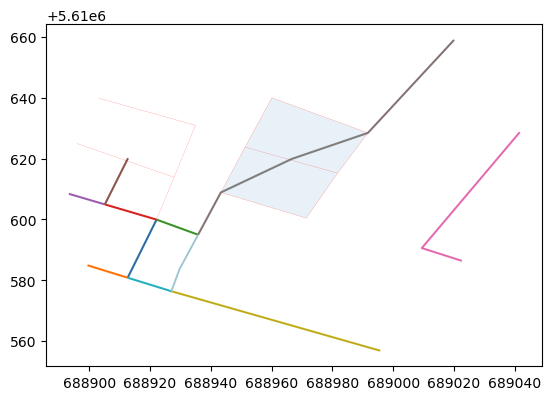

238


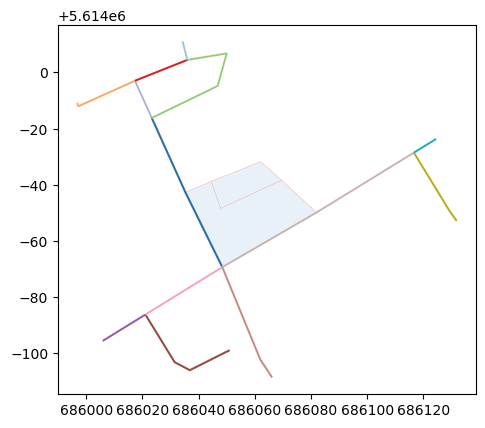

249


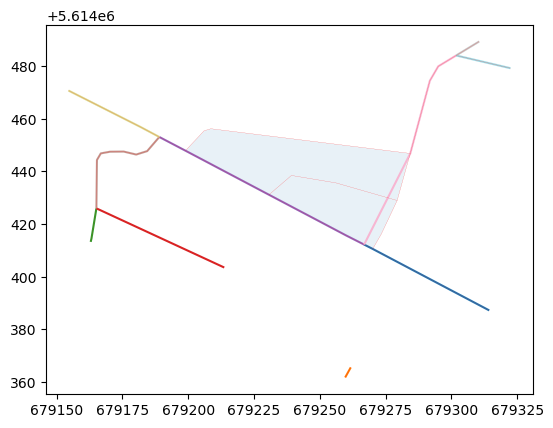

254


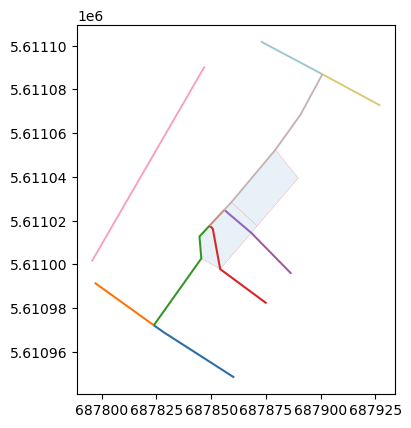

255


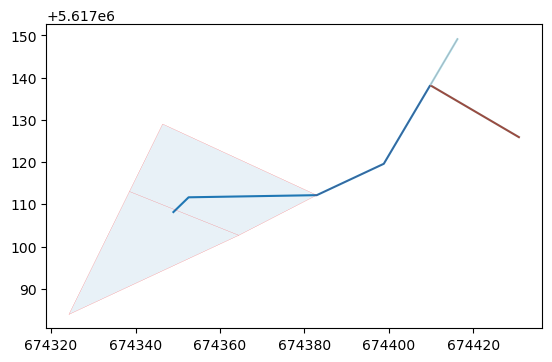

256


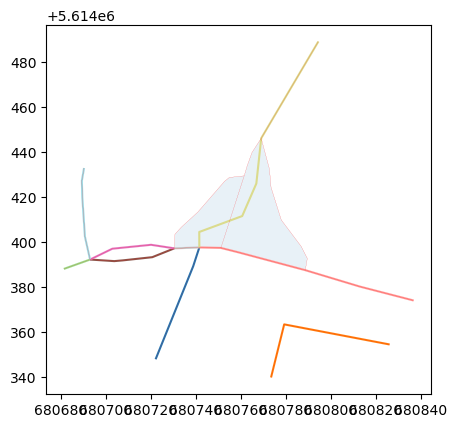

258


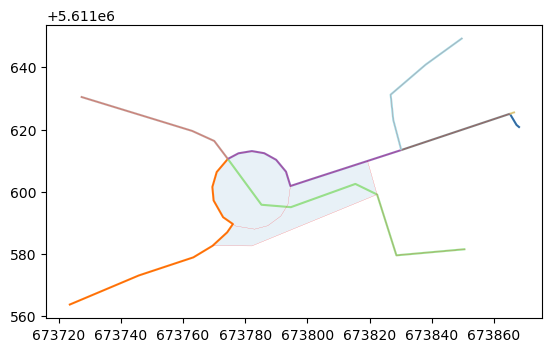

262


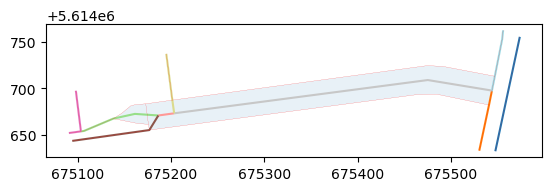

267


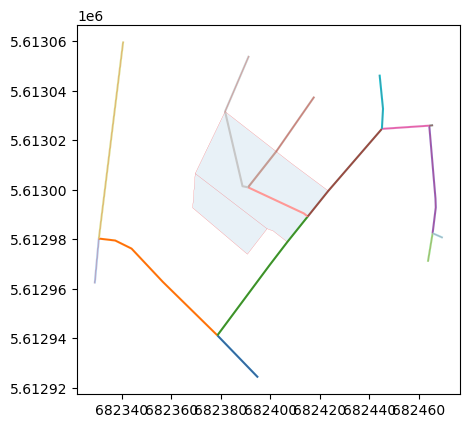

268


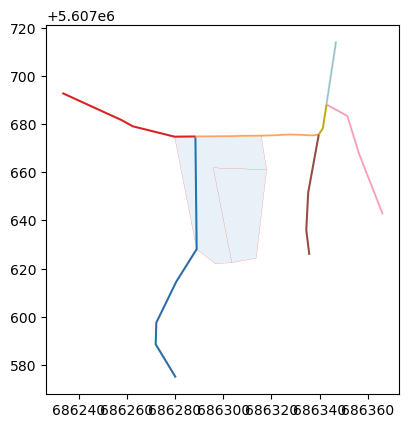

275


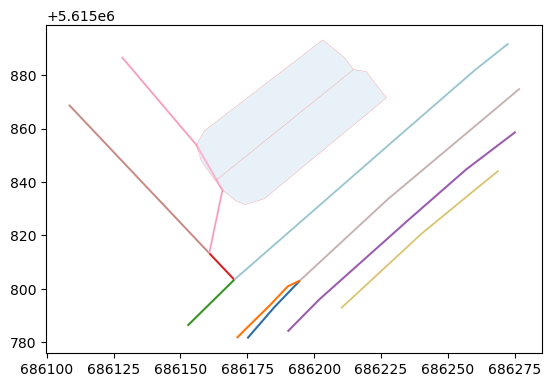

277


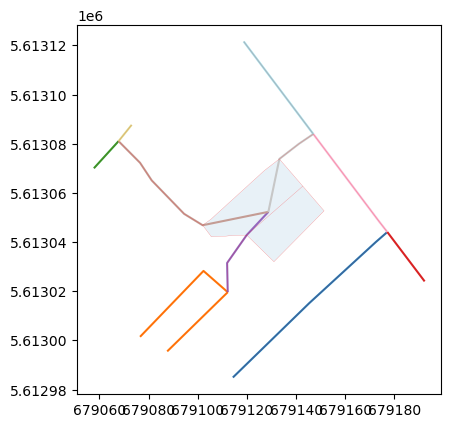

288


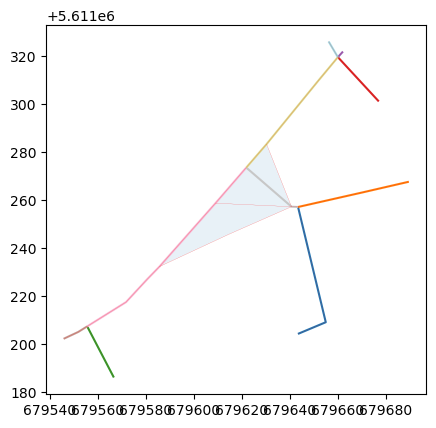

292


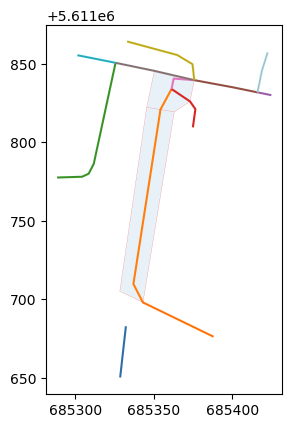

303


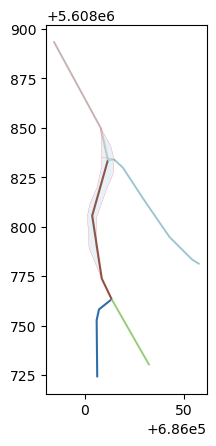

305


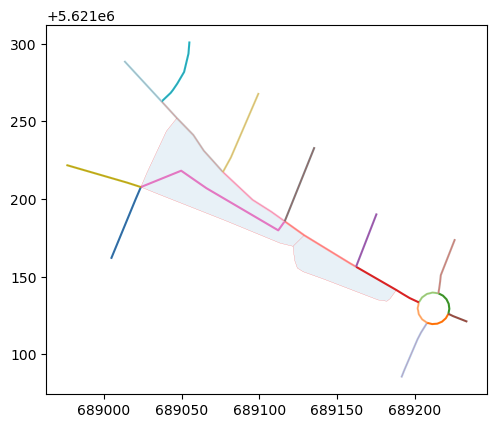

316


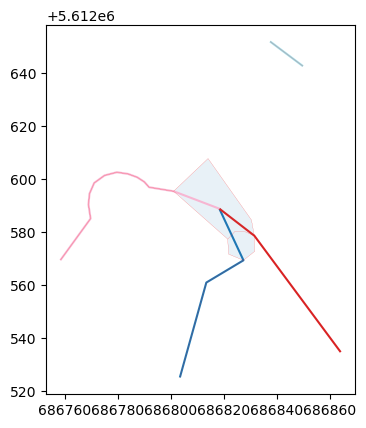

318


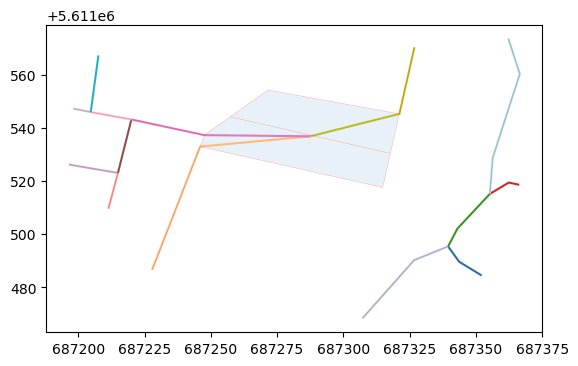

334


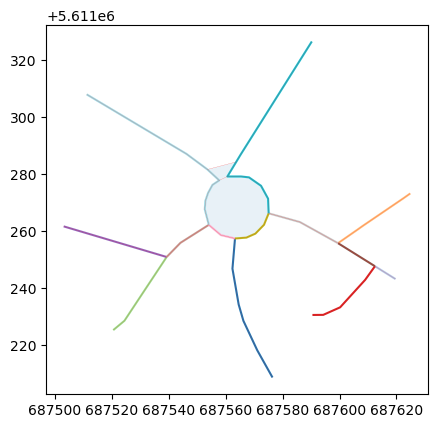

338


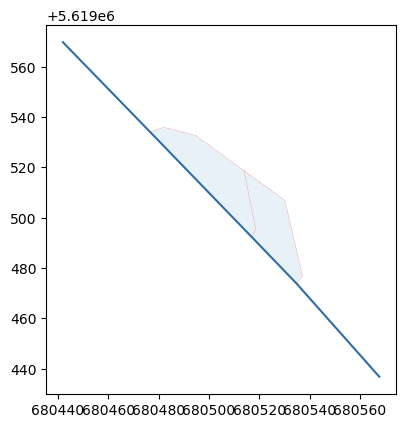

340


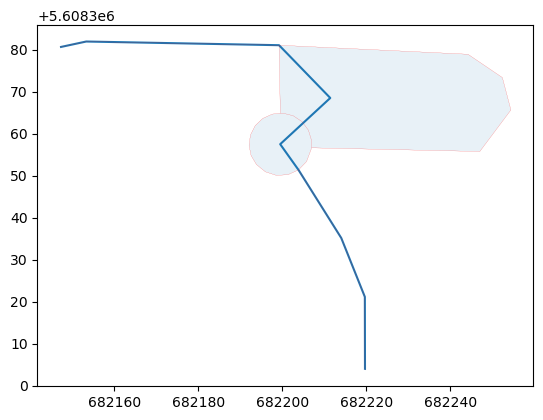

341


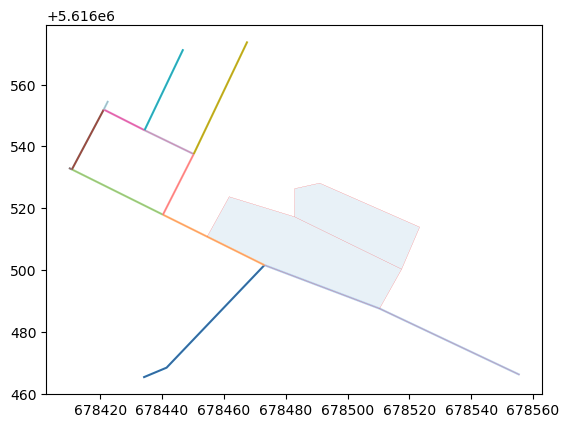

346


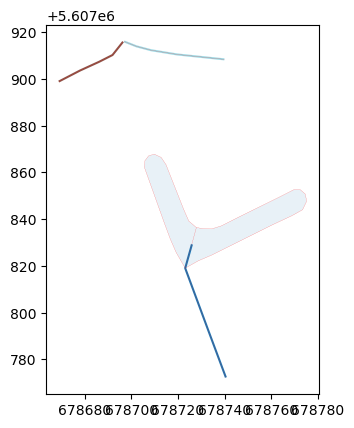

354


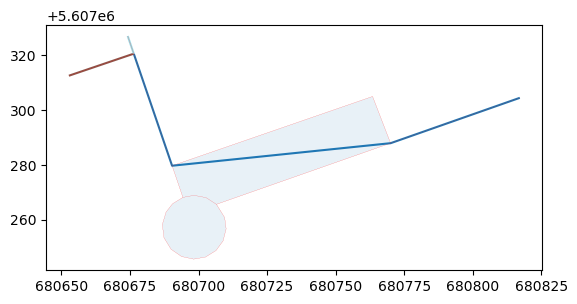

356


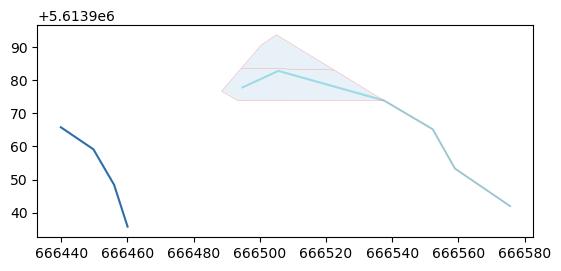

363


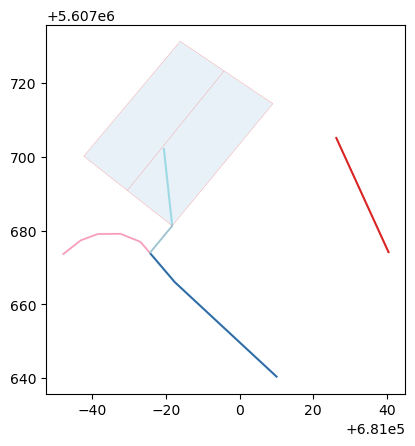

373


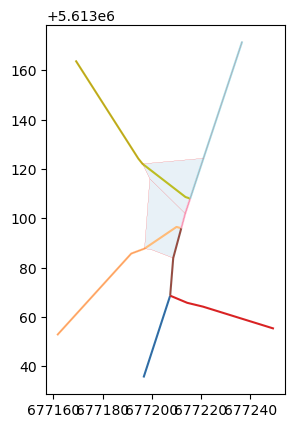

374


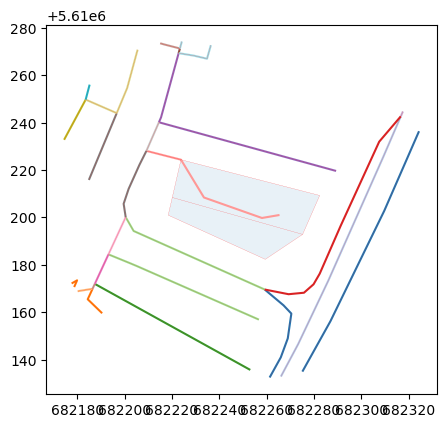

375


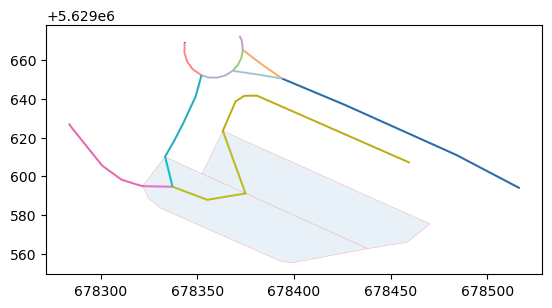

380


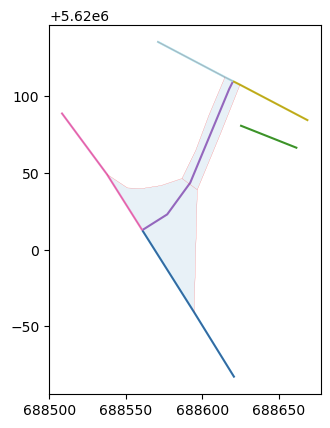

384


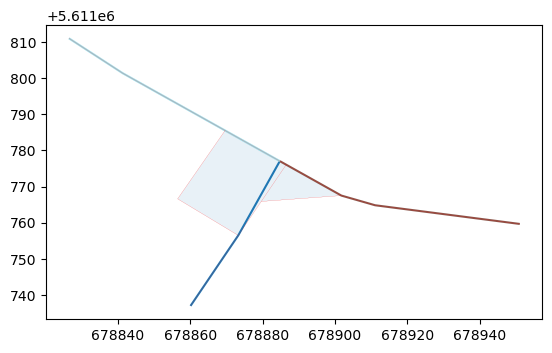

387


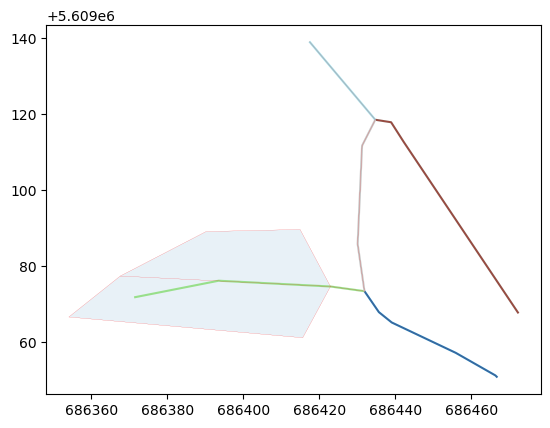

390


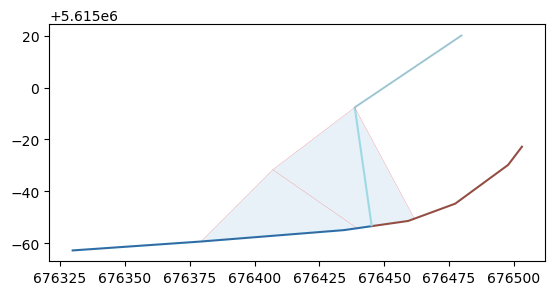

391


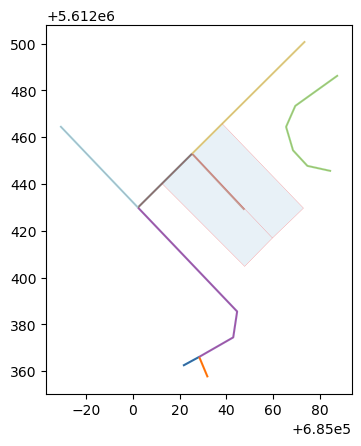

392


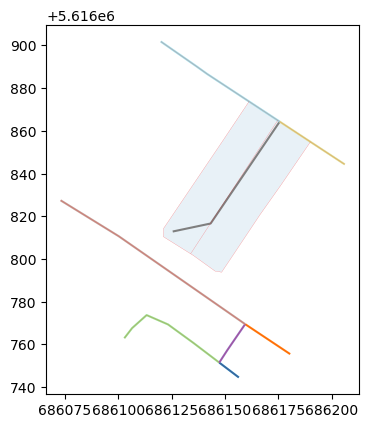

393


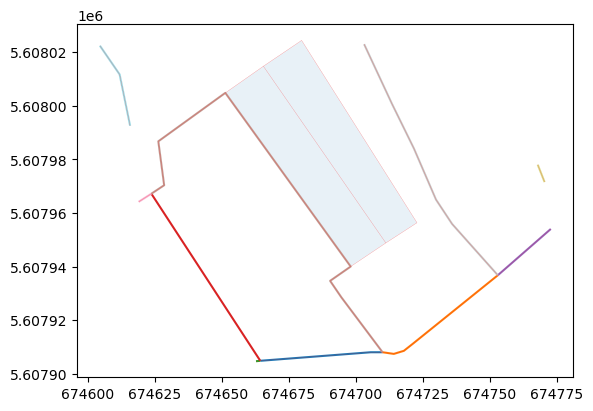

401


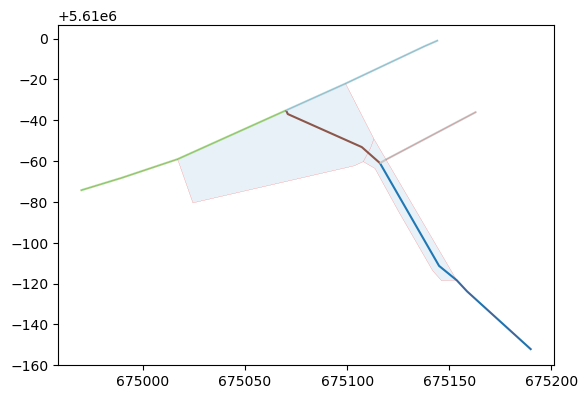

408


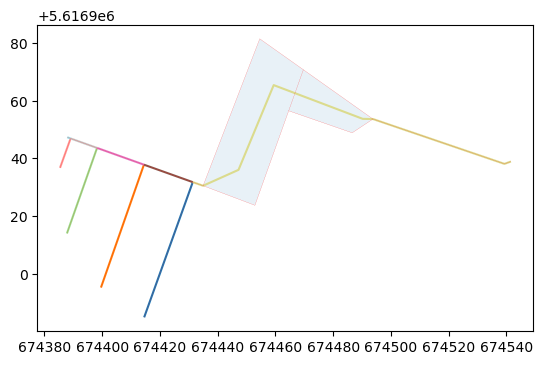

417


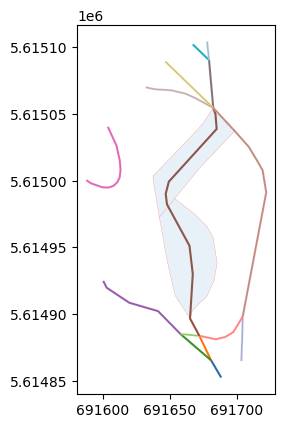

422


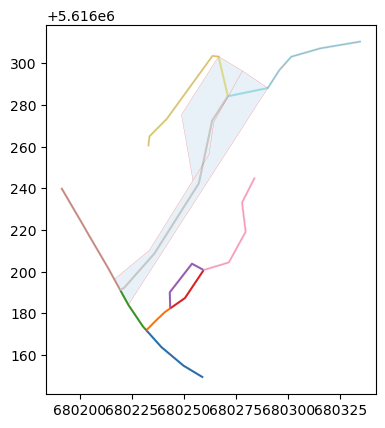

434


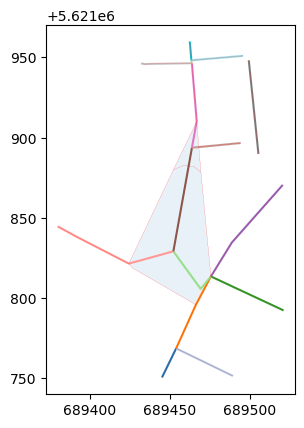

435


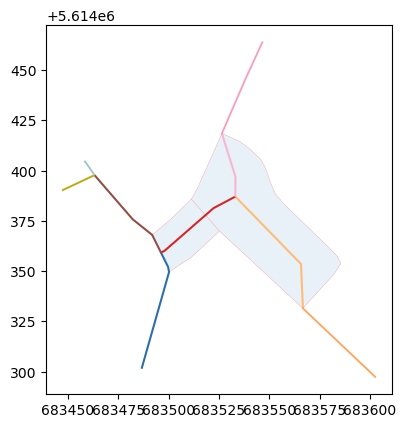

476


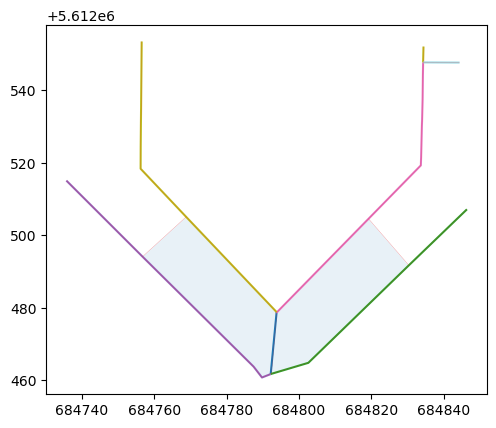

477


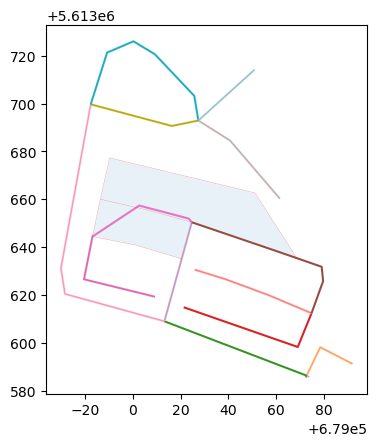

491


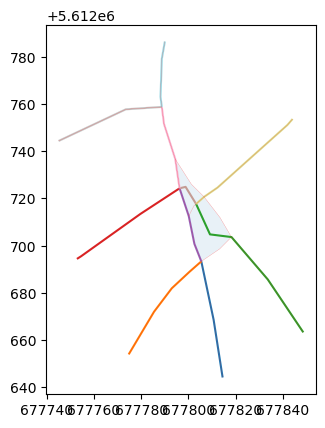

493


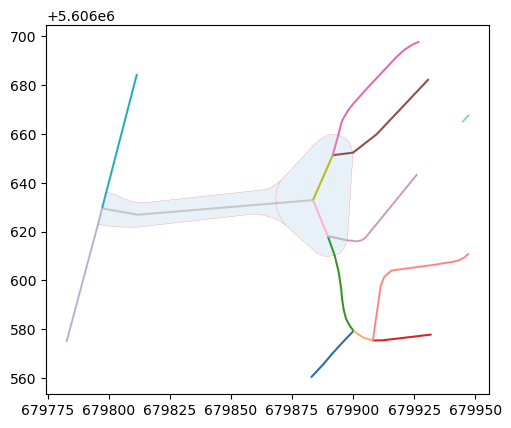

494


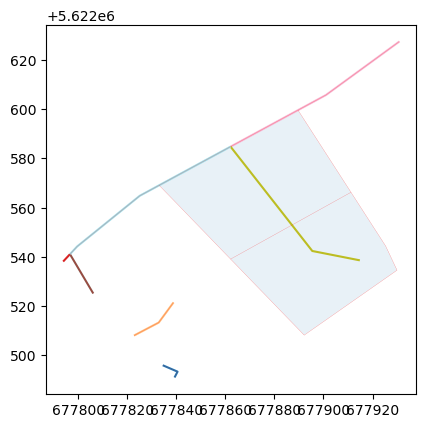

495


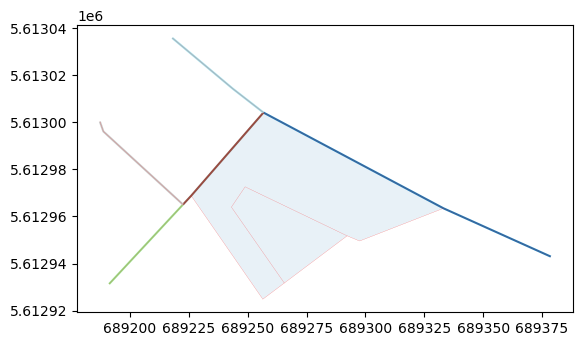

507


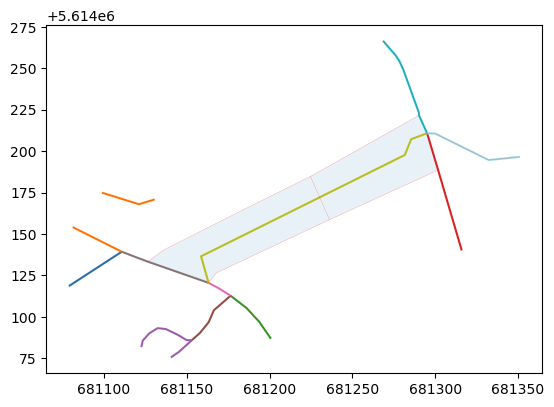

510


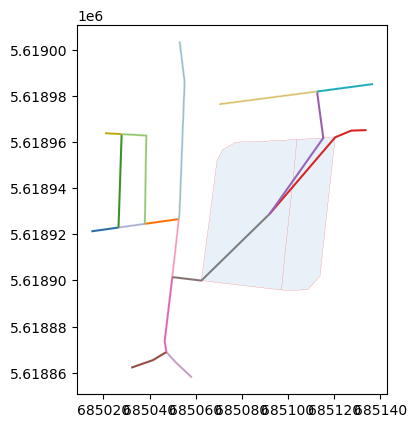

517


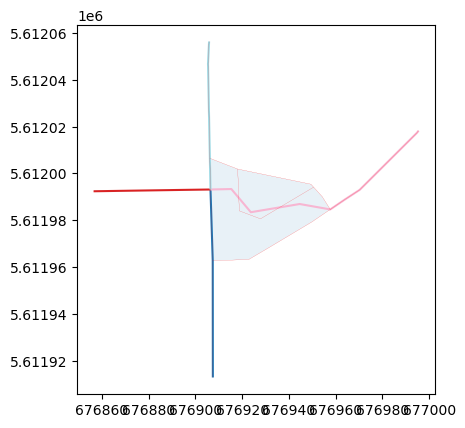

524


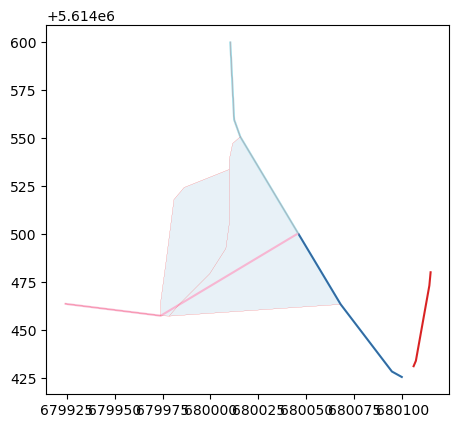

528


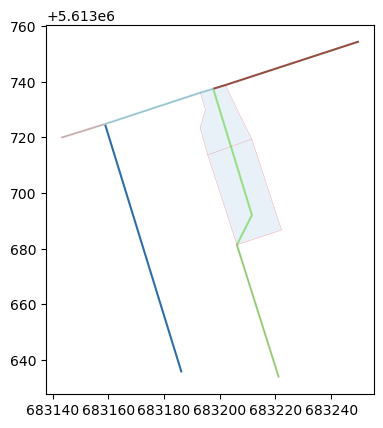

532


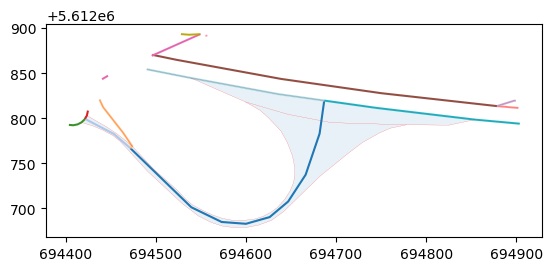

538


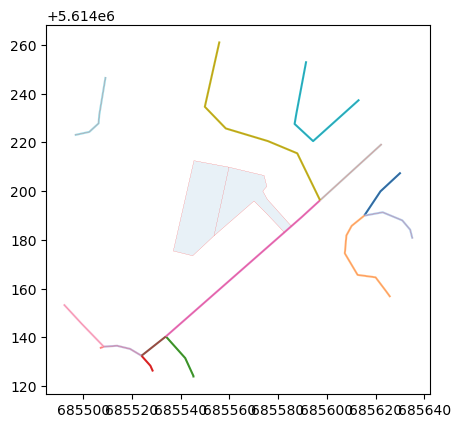

543


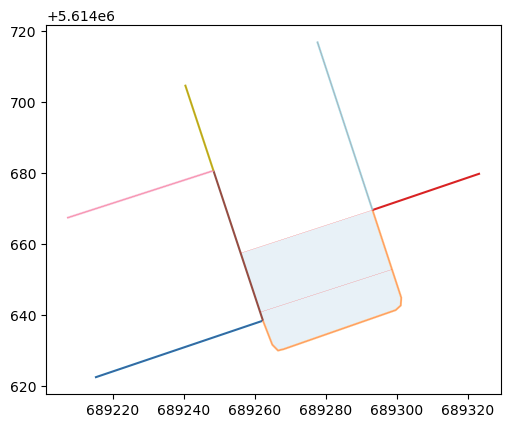

558


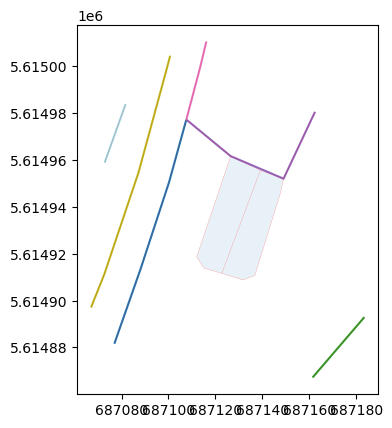

565


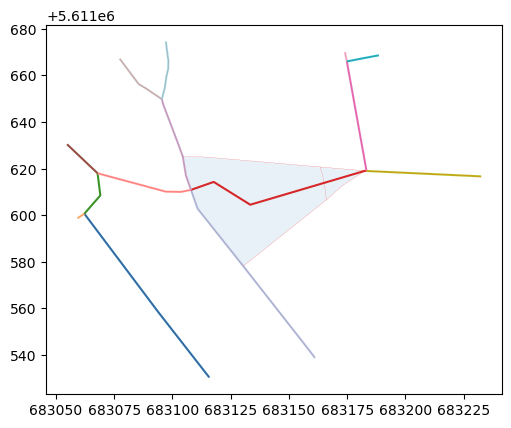

570


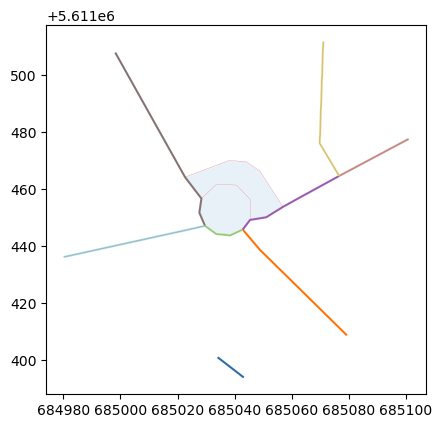

574


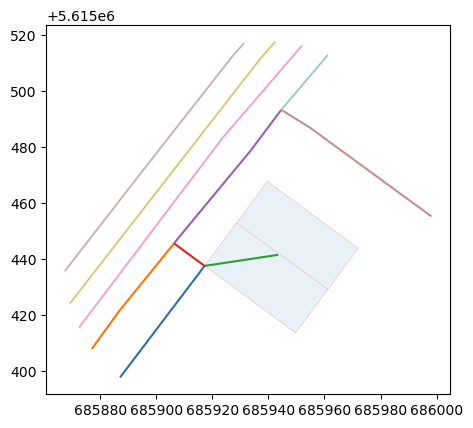

576


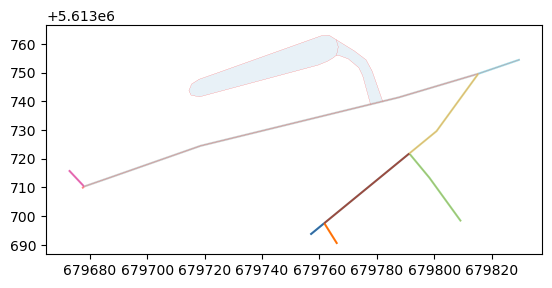

584


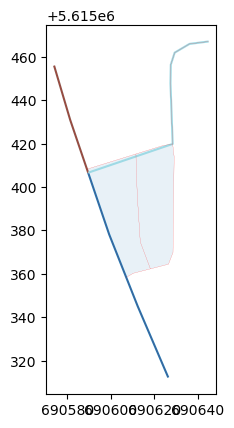

585


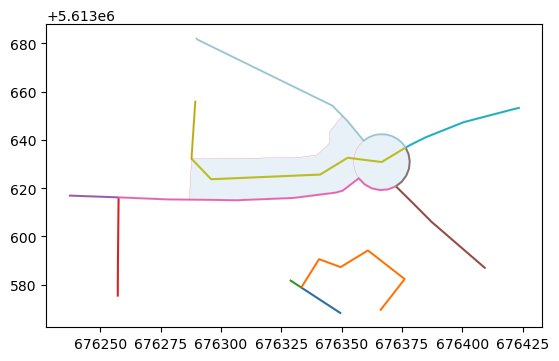

591


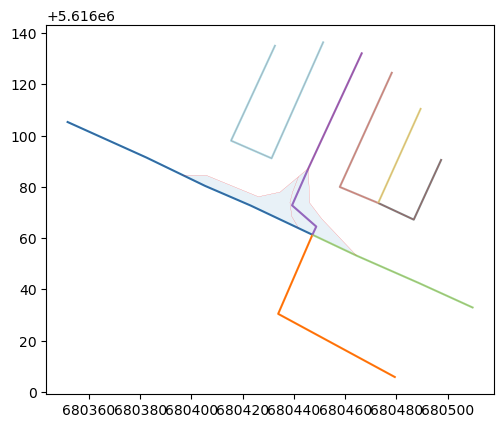

599


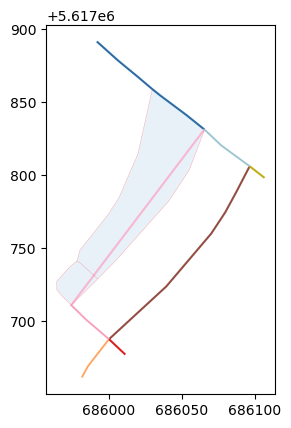

600


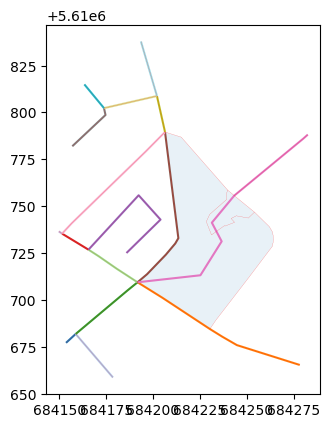

608


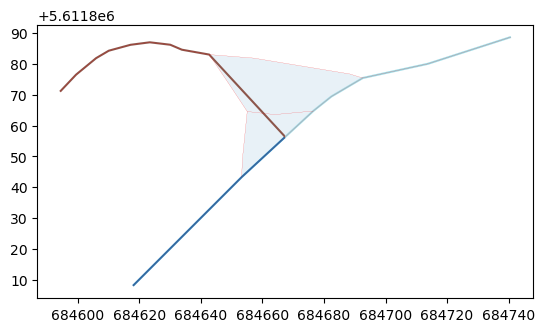

609


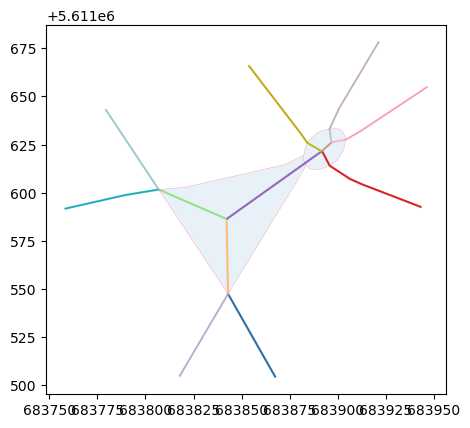

613


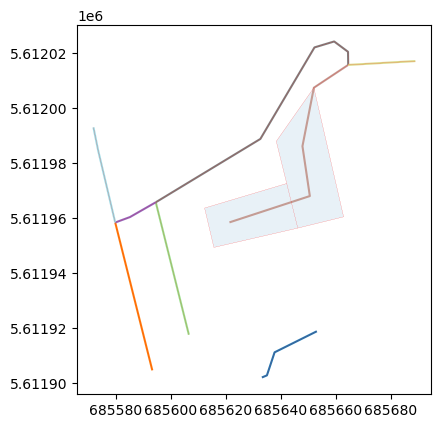

624


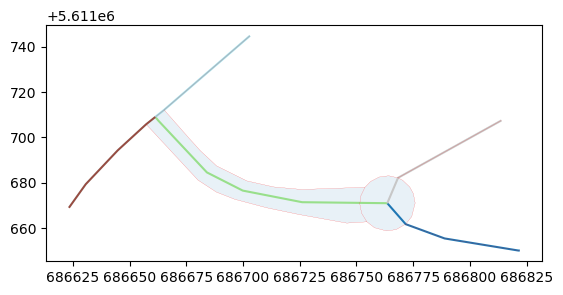

629


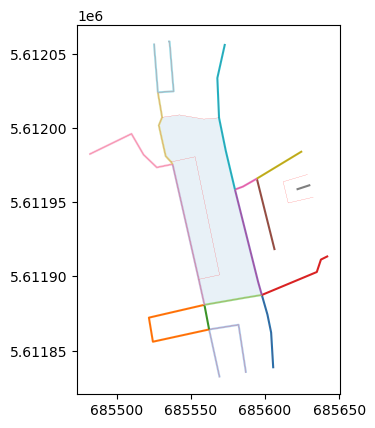

634


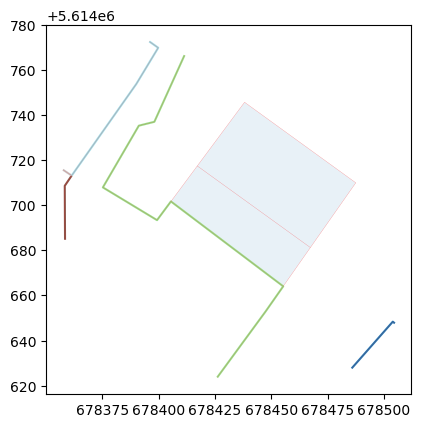

638


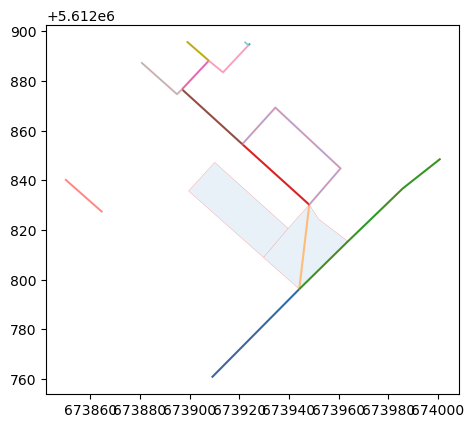

640


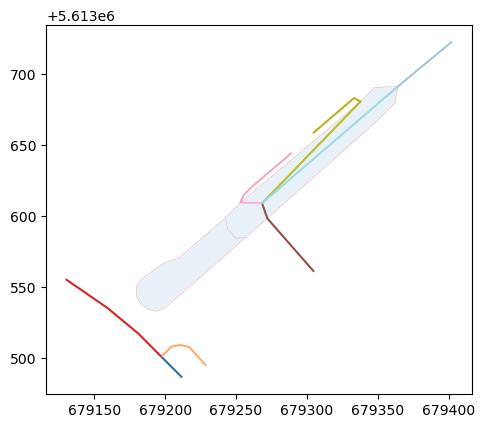

648


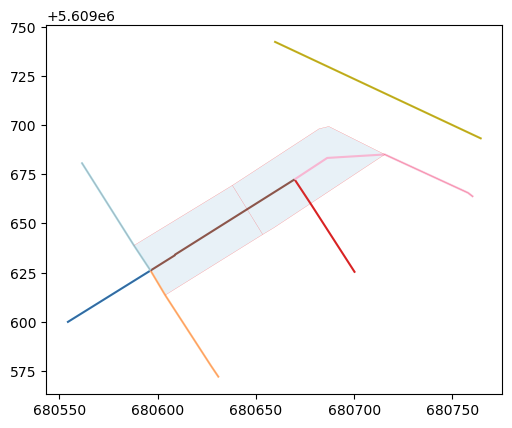

653


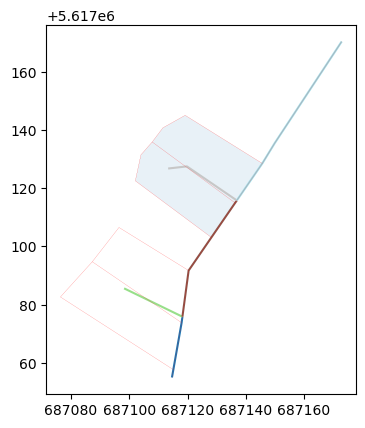

657


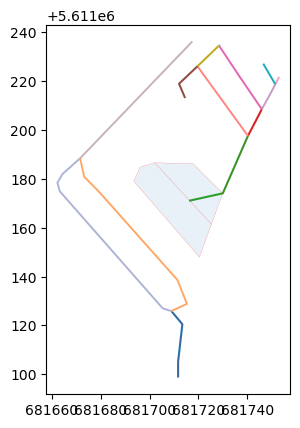

659


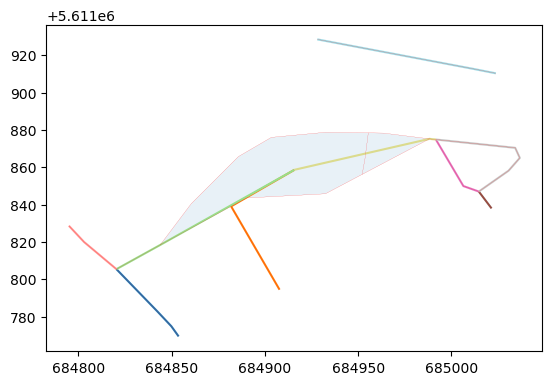

670


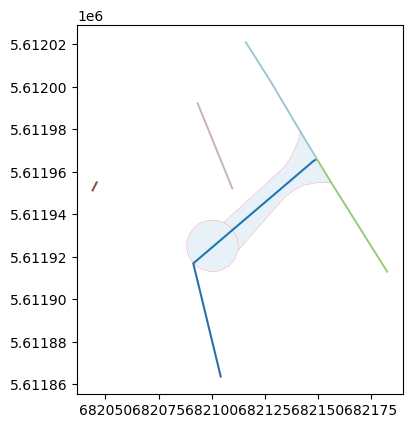

674


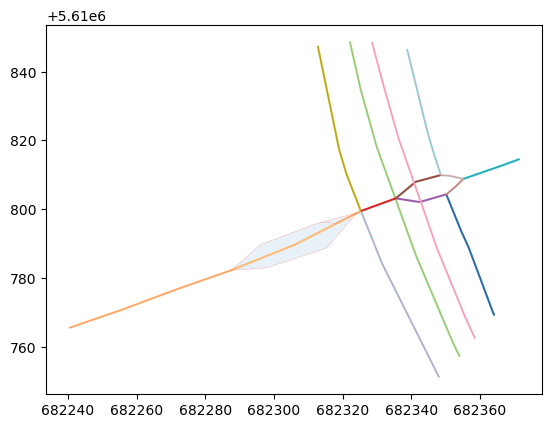

681


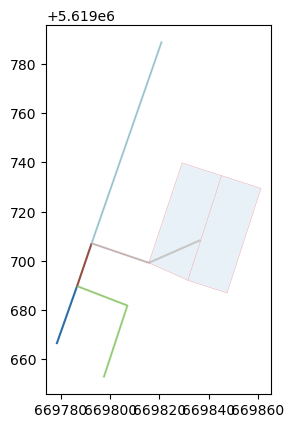

688


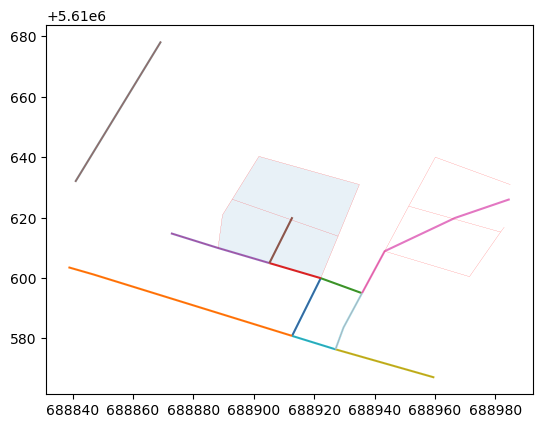

694


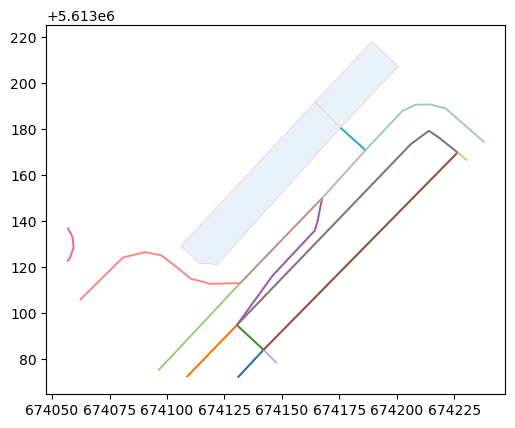

715


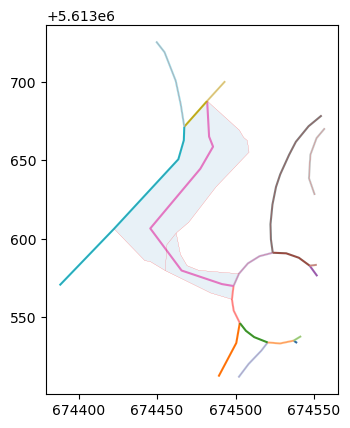

719


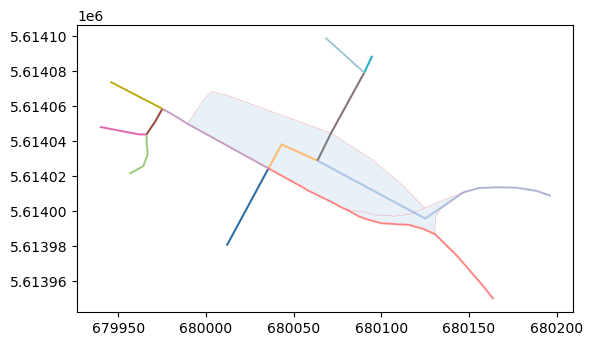

726


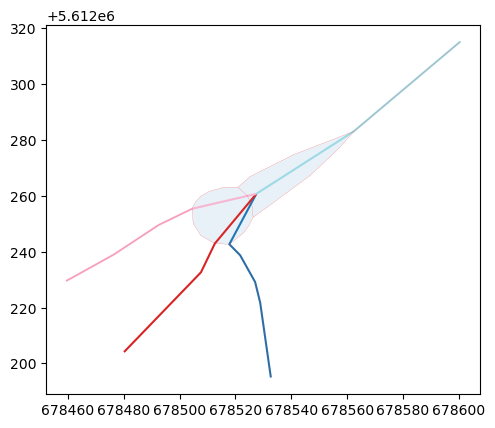

733


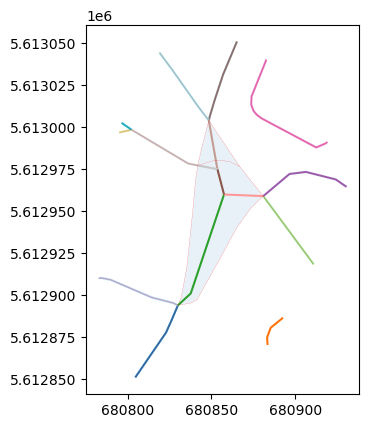

753


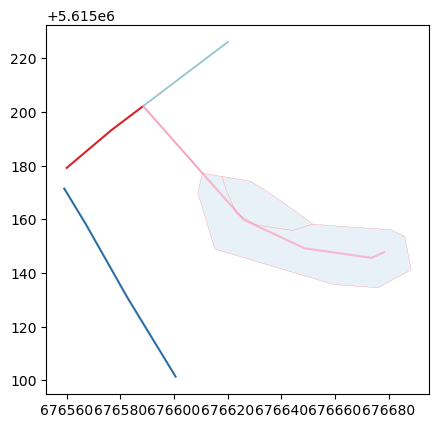

795


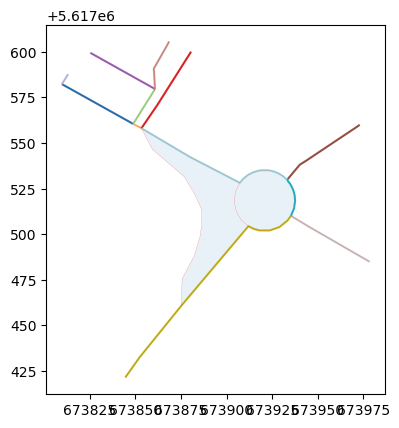

816


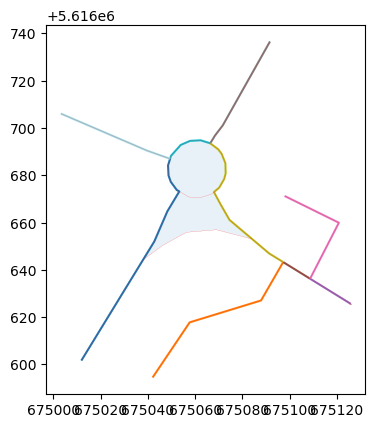

840


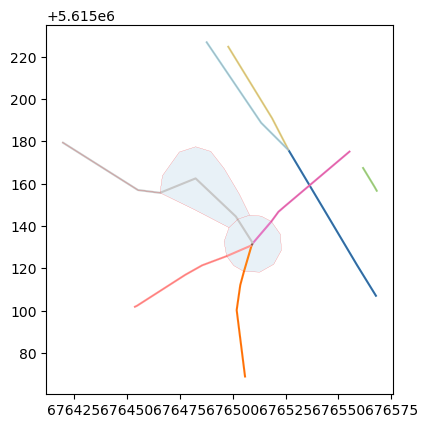

853


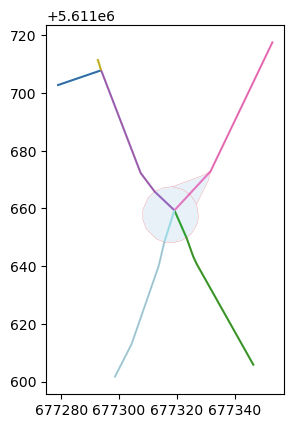

864


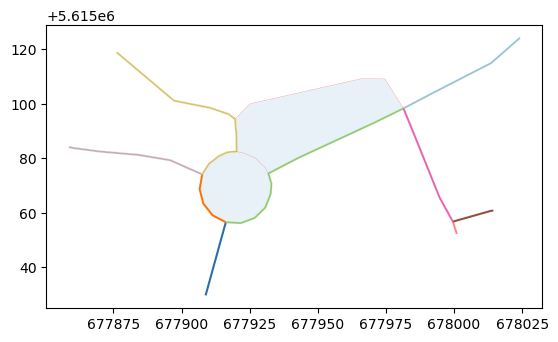

867


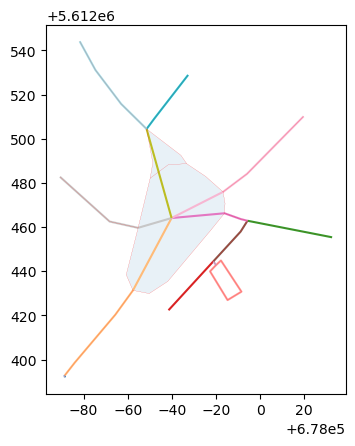

883


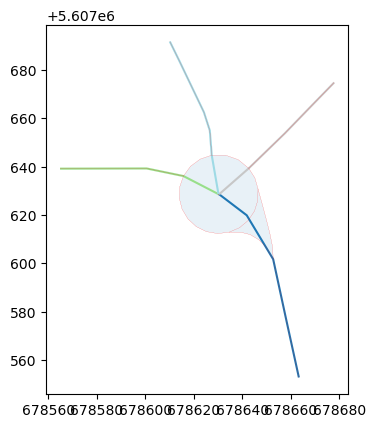

889


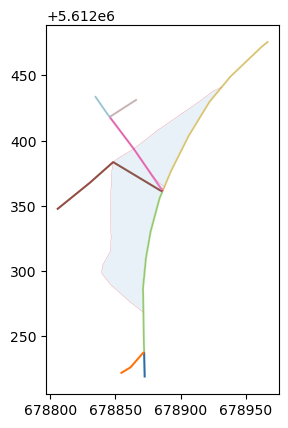

908


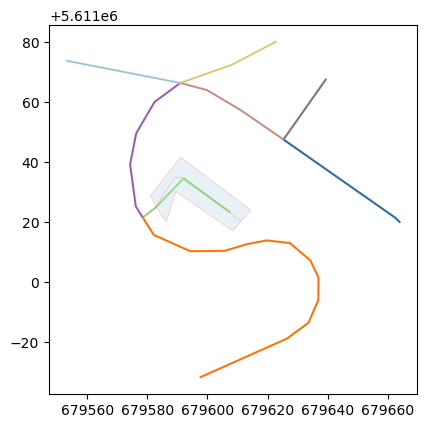

912


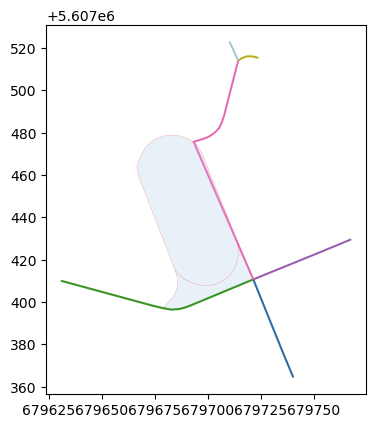

929


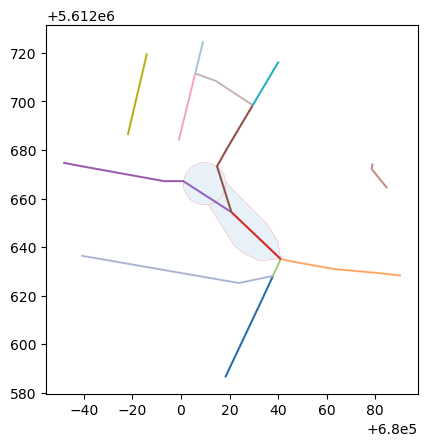

936


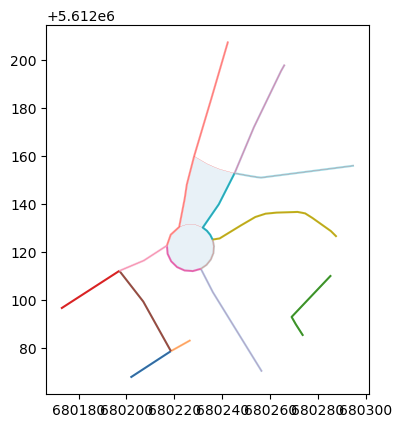

946


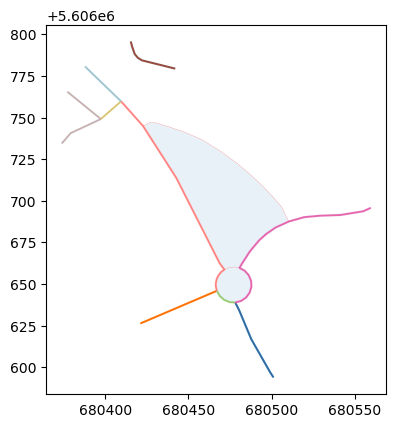

971


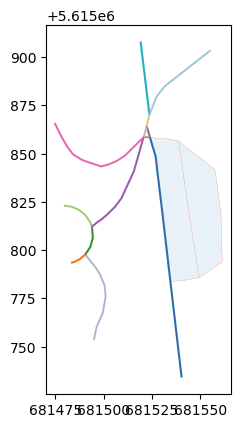

975


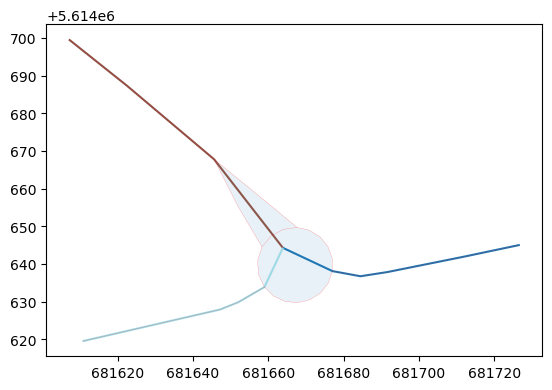

1009


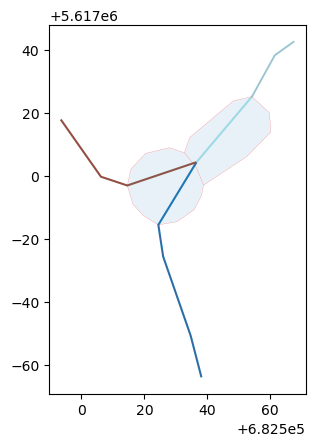

1045


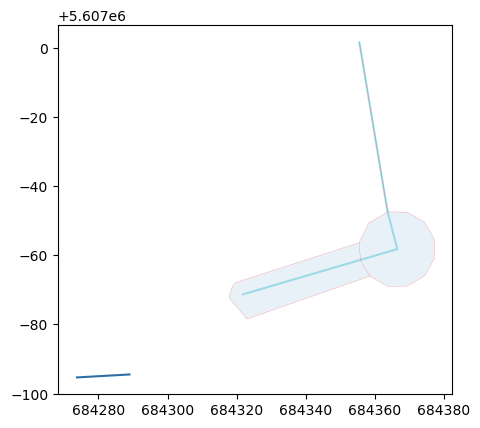

1110


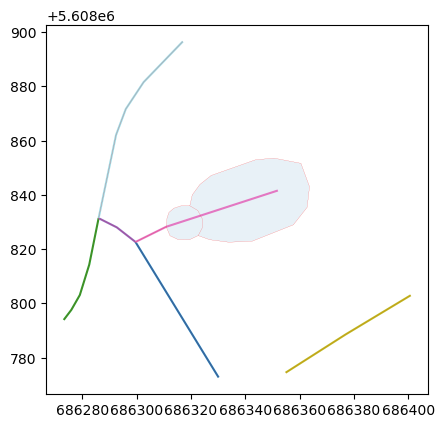

1131


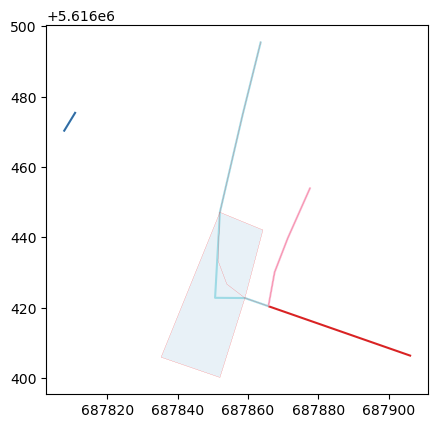

1152


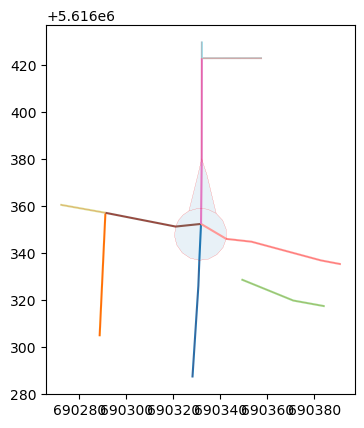

In [ ]:
for artifact in merged_pairs.itertuples():
    print(artifact.Index)

    # plot the results for visual verification
    geom = artifact.geometry
    ax = new_roads.clip(geom.buffer(50)).plot(zorder=2, cmap="tab20")
    gpd.GeoSeries([artifact.geometry]).plot(ax=ax, alpha=.1)
    roads.clip(geom.buffer(50)).plot(
        color="red",
        ax=ax,
        # categorical=True,
        # legend=True,
        linewidth=0.1,
    )
    plt.show()

why did the roundabout solution correctly work for: 840, 853, 883? but not all the other examples